## Importar librerías

In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import pandas as pd
import numpy as np

from pathlib import Path
import random
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Cargar imágenes ligeramente corruptas

In [2]:
import torch_directml
dml=torch_directml.device()
torch.set_default_device(dml)

## Preprocesamiento

In [10]:
data = pd.read_feather("NN_INPUT.feather");
#data.tail(50)
data

,Path,FUM,EXP,INAC
0,2000/abr/p0423001.jpg,0.0,0.0,1.0
1,2000/abr/p0423002.jpg,1.0,0.0,0.0
2,2000/abr/p0423003.jpg,1.0,0.0,0.0
3,2000/abr/p0424001.jpg,1.0,0.0,0.0
4,2000/abr/p0424002.jpg,1.0,0.0,0.0
...,...,...,...,...
21926,2023/mar/p0316234.jpeg,1.0,0.0,0.0
21927,2023/mar/p0317231.jpeg,1.0,1.0,0.0
21928,2023/mar/p0317232.jpeg,1.0,1.0,0.0
21929,2023/mar/p0317233.jpeg,1.0,1.0,0.0


In [11]:
# Desechar las filas inexistentes
drop=[]
for i,r in data.iterrows():
    if not Path(f"images/{r['Path']}").exists():
        drop.append(i)

data.drop(drop,inplace=True)
data

,Path,FUM,EXP,INAC
0,2000/abr/p0423001.jpg,0.0,0.0,1.0
1,2000/abr/p0423002.jpg,1.0,0.0,0.0
2,2000/abr/p0423003.jpg,1.0,0.0,0.0
3,2000/abr/p0424001.jpg,1.0,0.0,0.0
4,2000/abr/p0424002.jpg,1.0,0.0,0.0
...,...,...,...,...
21926,2023/mar/p0316234.jpeg,1.0,0.0,0.0
21927,2023/mar/p0317231.jpeg,1.0,1.0,0.0
21928,2023/mar/p0317232.jpeg,1.0,1.0,0.0
21929,2023/mar/p0317233.jpeg,1.0,1.0,0.0


In [12]:
# 0: INACTIVO
# 1: FUMAROLA
# 2: EXPLOSIÓN
# 3: FUMAROLA + EXPLOSIÓN
# 4: NO SÉ

In [13]:
def GEN(row):
    Image,FUM,EXP,INA = row.values
    values = np.zeros(5)
    if FUM>0:
        if EXP>0:
            values[3]=1
        else:
            values[1]=1
    elif EXP>0:
        values[2]=1
    elif INA>0:
        values[0]=1
    else:
        values[4]=1
    return pd.Series(values)

In [14]:
data=pd.concat([data,data.apply(GEN,axis=1)],axis=1)

In [15]:
data.drop(columns=["FUM","EXP","INAC"],inplace=True)

In [16]:
data.columns=["Path","Inactivo","Fumarola","Explosion","FumarolaExplosion","Unknown"]

In [17]:
data.describe()

,Inactivo,Fumarola,Explosion,FumarolaExplosion,Unknown
count,21931.000000,21931.000000,21931.000000,21931.000000,21931.000000
mean,0.142492,0.406229,0.018786,0.363230,0.069263
std,0.349562,0.491139,0.135772,0.480941,0.253906
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
data

,Path,Inactivo,Fumarola,Explosion,FumarolaExplosion,Unknown
0,2000/abr/p0423001.jpg,1.0,0.0,0.0,0.0,0.0
1,2000/abr/p0423002.jpg,0.0,1.0,0.0,0.0,0.0
2,2000/abr/p0423003.jpg,0.0,1.0,0.0,0.0,0.0
3,2000/abr/p0424001.jpg,0.0,1.0,0.0,0.0,0.0
4,2000/abr/p0424002.jpg,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
21926,2023/mar/p0316234.jpeg,0.0,1.0,0.0,0.0,0.0
21927,2023/mar/p0317231.jpeg,0.0,0.0,0.0,1.0,0.0
21928,2023/mar/p0317232.jpeg,0.0,0.0,0.0,1.0,0.0
21929,2023/mar/p0317233.jpeg,0.0,0.0,0.0,1.0,0.0


## Carga de datos

In [18]:
path = Path("images/")
classdict = {}
for img in path.ls():
    classdict[img.name]=img.stem.split("_")[:3]
    classdict[img.name][0]=float(classdict[img.name][0])
def get_class(file):
    return classdict[file.name]
files = path.ls()
#test simple case
print(files[0],get_class(files[0]))

images\1999 [1999.0]


In [19]:
data[data["Path"]=="2000/abr/p0424002.jpg"].iloc[0]

Path                 2000/abr/p0424002.jpg
Inactivo                               0.0
Fumarola                               1.0
Explosion                              0.0
FumarolaExplosion                      0.0
Unknown                                0.0
Name: 4, dtype: object

In [20]:
def getter(l):
    def f(path):
        cpath=str(path)[7:].replace("\\","/")
        s=data[data["Path"]==cpath]
        if s.shape[0]==0:
            print("MISSING IMAGE:",path)
            return 0 if l!=5 else 1
        return s.iloc[0,l]
    return f

In [24]:
getter(2)(r"images\2002\may\p0527021.jpg")

0.0

In [25]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert=False,
                             max_rotate=90,
                             max_lighting=0.1,
                             max_zoom=1.05,
                             max_warp=0.01)
    
    dataset = fv.DataBlock(blocks    = (fv.ImageBlock, 
                                        fv.RegressionBlock,
                                        fv.RegressionBlock,
                                        fv.RegressionBlock,
                                        fv.RegressionBlock,
                                        fv.RegressionBlock),
                        n_inp     = 1,
                        get_items = fv.get_image_files,
                           
                        getters   = (lambda x: x, 
                                     getter(1), 
                                     getter(2), 
                                     getter(3), 
                                     getter(4), 
                                     getter(5)),
                           
                        splitter  = fv.RandomSplitter(1/20),
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms= tfms,
                       )
    dataset.device=dml
    return dataset.dataloaders(folder, bs=batch_size)


In [26]:
gc.collect()
torch.cuda.empty_cache()

C:\Users\alexi\mambaforge\lib\site-packages\torch\nn\functional.py:4341: UserWarning: The operator 'aten::linspace.out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at D:\a\_work\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch.affine_grid_generator(theta, size, align_corners)


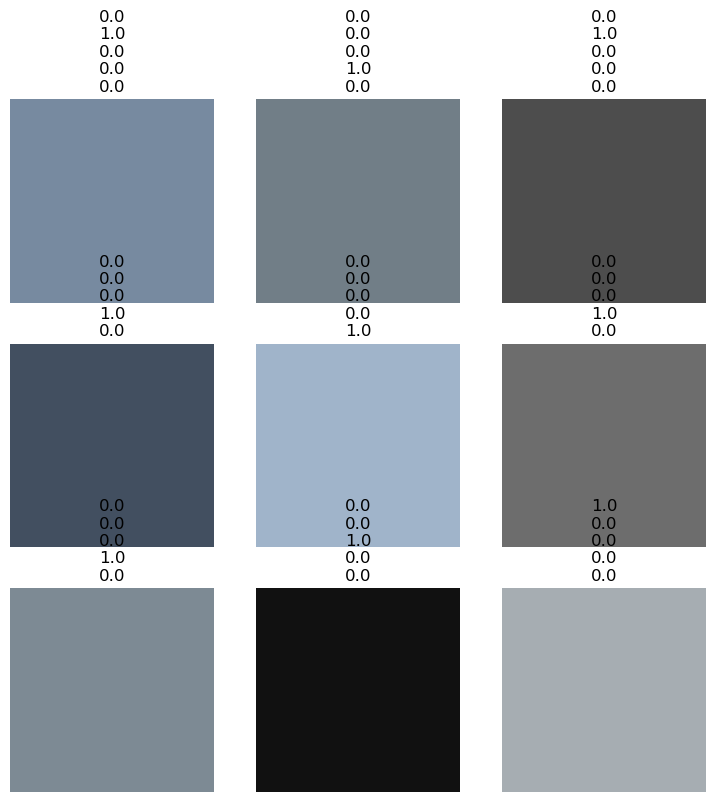

In [28]:
dataloader = load_data("images/",128,64*4).to(dml)
dataloader.show_batch()

## Modelo convolucional

In [32]:
# Definir una nueva clase para el modelo de regresión de imágenes

class ModelClass(nn.Module):
    def __init__(self, **kwargs):
        super(ModelClass, self).__init__()
        
        # Definir las capas convolucionales
        # Cada capa consta de una convolución, una normalización por lotes y una activación ReLU
        # El número de canales, tamaño del kernel, stride y padding
        # También se han agregado algunas capas de max pooling para reducir las dimensiones espaciales y aumentar el campo receptivo

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=32768, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=5)
        
        # Define una capa de dropout para prevenir el sobreajuste
        # La probabilidad de dropout se puede ajustar según tus datos y tarea
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Pasa la entrada a través de las capas convolucionales
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        print(x.shape,x.flatten(start_dim=1).shape)
        
        # Aplana la salida de la última capa convolucional
        x = torch.flatten(x, start_dim=1)
        
        # Pasa la salida aplanada a través de las capas lineales
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Regresa la salida
        return x

In [35]:
def getMetric(i):
    def f(y,yp):
        return F.MSE_loss(y[:,i],yp[:,i])
    return f

metrics = [getMetric(i) for i in range(5)]
def combined_metric(yp,*ys):
    y=torch.stack(ys).T
    return sum([m(y,yp) for m in metrics])

In [36]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean= torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s

def create_learner(**kwargs):
    learn = fv.vision_learner(dataloader, ModelClass, opt_func=fv.Adam, normalize=False, **kwargs)
    learn.device = dml
    learn.model = nn.Sequential(Normalizer().to(dml), learn.model.to(dml)).to(dml)
    return learn.to_fp16()

## Entrenamiento

In [24]:
gc.collect()
torch.cuda.empty_cache()
learn = create_learner(loss_func=combined_metric, n_out=5,metrics=[combined_metric])

In [ ]:
lr=learn.lr_find()

In [26]:
learn.fit_one_cycle(8,lr_max=1e-2,div=0.8,pct_start=0.75)

epoch,train_loss,valid_loss,combined_metric,time
0,5.457054,1.428286,1.428286,04:53
1,3.893225,1.337302,1.337302,04:58
2,3.062561,1.194819,1.194819,05:21
3,2.634293,1.144651,1.144651,06:19
4,2.352066,1.156426,1.156426,06:26
5,2.180657,1.141351,1.141351,06:25
6,2.046990,1.140417,1.140417,06:19
7,1.957081,1.131480,1.131480,05:48


In [31]:
learn.fit_flat_cos(50,lr=1e-2)

epoch,train_loss,valid_loss,combined_metric,time
0,1.590959,1.074289,1.074289,04:56
1,1.420735,1.063979,1.063979,04:52
2,1.282193,1.063101,1.063101,04:52
3,1.177903,1.061328,1.061328,04:54
4,1.115710,1.065756,1.065756,04:53
5,1.074493,1.063406,1.063406,04:53
6,1.052928,1.061743,1.061743,05:02
7,1.041814,1.054905,1.054905,05:06
8,1.036200,1.056461,1.056461,05:06
9,1.030808,1.054531,1.054531,05:03


In [32]:
learn.save("custom_model")

Path('models/custom_model.pth')

In [37]:
x,y1,y2,y3,y4,y5 = dataloader.one_batch()
print("APPLY")
m=ModelClass()
y=torch.stack([y1,y2,y3,y4,y5]).T
yp=torch.nn.functional.softmax(m(x.to(dml))).round(decimals=2)
print("y",torch.argmax(y,dim=1))
print("p",torch.argmax(yp,dim=1))

APPLY
torch.Size([256, 128, 16, 16]) torch.Size([256, 32768])
y tensor([3, 1, 4, 4, 1, 3, 3, 0, 0, 1, 3, 3, 0, 1, 3, 2, 3, 1, 1, 1, 1, 1, 2, 1,
        4, 1, 3, 1, 4, 1, 1, 3, 2, 3, 3, 0, 1, 4, 1, 3, 1, 1, 3, 1, 0, 3, 4, 1,
        3, 3, 3, 1, 3, 1, 0, 1, 1, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 0, 1, 1, 3, 0,
        1, 1, 3, 1, 1, 3, 0, 3, 1, 1, 3, 3, 1, 1, 0, 3, 1, 3, 2, 3, 3, 1, 3, 3,
        3, 1, 1, 1, 3, 0, 1, 1, 3, 1, 3, 3, 0, 3, 1, 0, 3, 3, 1, 1, 3, 3, 0, 3,
        3, 3, 3, 0, 1, 3, 3, 3, 1, 4, 3, 3, 0, 1, 1, 1, 1, 1, 3, 0, 1, 0, 3, 1,
        3, 4, 3, 1, 4, 1, 3, 1, 0, 3, 1, 4, 1, 1, 1, 3, 1, 1, 3, 1, 0, 0, 1, 3,
        1, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1,
        0, 3, 1, 3, 3, 1, 0, 1, 1, 0, 1, 3, 1, 4, 3, 3, 1, 1, 3, 0, 1, 3, 3, 1,
        3, 3, 4, 1, 1, 1, 3, 1, 1, 1, 0, 3, 4, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 2, 2, 3, 0, 1, 1, 3, 3, 0, 4, 3],
       device='privateuseone:0')
p TensorImage([2, 0, 2, 0, 2, 2, 1, 2, 0, 3, 0

C:\Users\alexi\mambaforge\lib\site-packages\torch\_tensor.py:1295: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)
